In [82]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

In [83]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

##Data generation

In [84]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([3., 0.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p_data = 0.7 # prob of the first peak in data space
N = 10000 # amount of data
batch_size = 100
num_epoches = 250
z_dim = 2

In [85]:
c = torch.distributions.Bernoulli(p_data). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [86]:
X = c * a + (1 - c) * b
Y = torch.cat((X, c), 1)

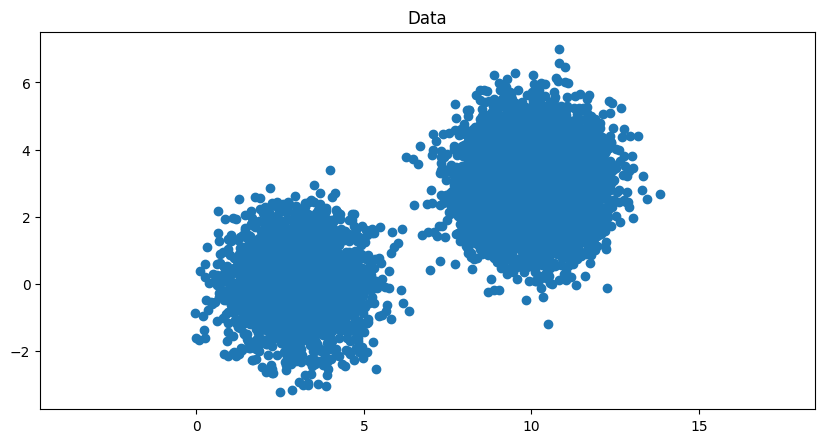

In [87]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Data')
plt.axis('equal')
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu());

In [98]:
class VAE_MoG_prior(nn.Module):
  def __init__(self):
    super(VAE_MoG_prior, self).__init__()

    self.fc0 = nn.Linear(2, 5) # for encoder
    self.fc1 = nn.Linear(5, 10)
    self.fc2 = nn.Linear(10, z_dim) 
    self.fc3 = nn.Linear(10, z_dim)

    self.fc4 = nn.Linear(z_dim, 10) # for decoder
    self.fc5 = nn.Linear(10, 5)
    self.fc6 = nn.Linear(5, 2)
    
  def encode(self, x):
    h = torch.relu(self.fc0(x))
    g = torch.relu(self.fc1(h))
    return self.fc2(g), self.fc3(g) # mu and logvar -- parameters of q_{phi}
    
  def reparametrize(self, mu, logvar):
    std = torch.exp(logvar)
    eps = torch.randn_like(std)
    return mu + eps * std
  
  def decode(self, z):
    h = torch.relu(self.fc4(z))
    g = torch.relu(self.fc5(h))
    return self.fc6(g) # mu_0 -- parameter of p_{theta}

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparametrize(mu, logvar)
    return self.decode(z), mu, logvar

In [99]:
model = VAE_MoG_prior().to(device)

In [100]:
p_prior_logit = nn.Parameter(torch.rand(1, device=device, dtype=torch.float32)) # all the same with VAE_MoG_prior.ipynb, but p_prior requires_grad = True

m_1 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))
m_2 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))

logvar_1 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))
logvar_2 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))

In [101]:
print("Initialization of params:")
print("p_prior_logit =", p_prior_logit)
print("m_1 =", m_1)
print("m_2 =", m_2)
print("logvar_1 =", logvar_1)
print("logvar_2 =", logvar_2)

Initialization of params:
p_prior_logit = Parameter containing:
tensor([0.8214], device='cuda:0', requires_grad=True)
m_1 = Parameter containing:
tensor([0.5058, 0.5250], device='cuda:0', requires_grad=True)
m_2 = Parameter containing:
tensor([0.9773, 0.2692], device='cuda:0', requires_grad=True)
logvar_1 = Parameter containing:
tensor([0.8241, 0.0849], device='cuda:0', requires_grad=True)
logvar_2 = Parameter containing:
tensor([0.5737, 0.7914], device='cuda:0', requires_grad=True)


In [102]:
params = list(model.parameters()) + [p_prior_logit, m_1, logvar_1, m_2, logvar_2]

In [103]:
optimizer = optim.Adam(params=params, lr=1e-3)

$L = KL - ELH = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - KL(q_{\phi}(z|x)||p(z))) = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - \mathbb{E}_{q_{\phi}(z|x)}(\log{q_{\phi}(z|x)} - \log{p(z)}))$

$\mathbb{E}_{q_{\phi}(z|x)}\log{q_{\phi}(z|x)} = \int q_{\phi}(z|x)\log{q_{\phi}(z|x)}dz = -\frac{J}{2}\log{2\pi} - \frac{1}{2}\sum_{j = 1}^{J}{(1+\log{\sigma_{j}^{2}})}$

In [ ]:
import pdb

In [104]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                        scale=torch.tensor(1., device=device, dtype=torch.float32))

In [105]:
def loss_function(x, mu_0, mu, logvar, p_prior_logit, m_1, m_2, logvar_1, logvar_2): # mu_0 -- mean of p_{theta}; mu, logvar -- parameters of q_{phi}, p, m_1, m_2, logvar_1, logvar_2 -- parameters of prior p(z)
  g_1 = torch.distributions.Normal(loc = m_1, scale=logvar_1.exp())
  g_2 = torch.distributions.Normal(loc = m_2, scale = logvar_2.exp())
  z_0 = mu + std_normal.sample(mu.shape) * logvar.exp() ** 0.5 # reparametrization
  A = -0.5 * (1 + logvar)
  concat_tensor = torch.cat([(torch.log(torch.sigmoid(p_prior_logit)) + g_1.log_prob(z_0))[None], (torch.log(torch.sigmoid(1. - p_prior_logit)) + g_2.log_prob(z_0))[None]], dim=0)
  B = torch.logsumexp(concat_tensor, dim=0) #  1-MC approximation of E_{q_{phi}}[p(z)]
  KL = A - B
  p_theta = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
  ELH = p_theta.log_prob(x) # 1-MC approximation of expected log-likelihood
  return KL.mean() - ELH.mean()

In [106]:
dataloader = DataLoader(Y[:, 0:2], batch_size=batch_size, shuffle=True)

In [107]:
for epoch in tqdm(range(num_epoches)):
  for batch in dataloader:
    mu_0, mu, logvar = model(batch)
    loss = loss_function(batch, mu_0, mu, logvar, p_prior_logit, m_1, m_2, logvar_1, logvar_2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  if epoch % 50 == 0:
    print("loss =", loss.cpu().detach().numpy())

  0%|          | 1/250 [00:00<03:58,  1.05it/s]

loss = 30.50297


 20%|██        | 51/250 [00:47<03:05,  1.07it/s]

loss = 3.3889377


 40%|████      | 101/250 [01:34<02:18,  1.08it/s]

loss = 3.3570592


 60%|██████    | 151/250 [02:20<01:30,  1.09it/s]

loss = 2.8861609


 80%|████████  | 201/250 [03:05<00:44,  1.10it/s]

loss = 2.813235


100%|██████████| 250/250 [03:50<00:00,  1.09it/s]


##Generation

In [108]:
p_prior = torch.sigmoid(p_prior_logit)

In [109]:
bern = torch.distributions.Bernoulli(p_prior).sample((1000, )).view(-1, 1)
g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1.exp()) ** 0.5).sample((1000, ))
g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2.exp()) ** 0.5).sample((1000, ))

pr_samples = bern * g_1 + (1 - bern) * g_2 # get 1000 samples from trained prior

In [110]:
mu_post = model.decode(pr_samples).detach() #means of posterior dustributions

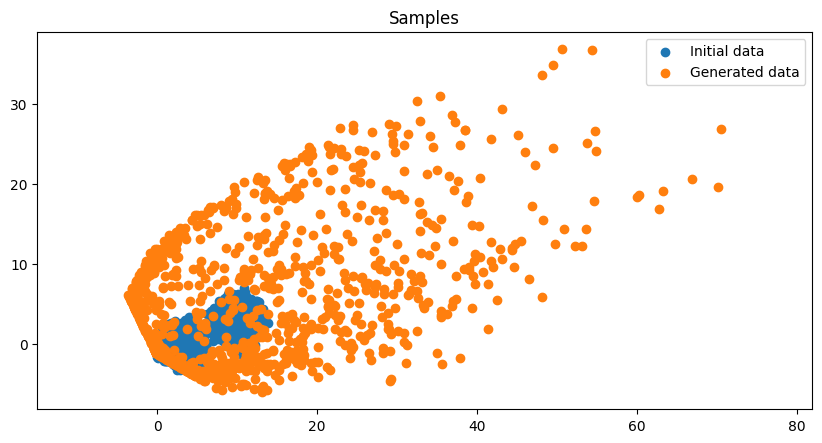

In [111]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(mu_post[:, 0].cpu(), mu_post[:, 1].cpu(), label='Generated data')
plt.axis('equal')
plt.legend();

##Prior visualization

In [112]:
print("Prior parameters:")
print("p_prior = ", p_prior.detach().cpu().numpy())
print("m_1 =", m_1.detach().cpu().numpy(), "logvar_1 =", logvar_1.detach().cpu().numpy())
print("m_2 =", m_2.detach().cpu().numpy(), "logvar_2 =", logvar_2.detach().cpu().numpy())

Prior parameters:
p_prior =  [0.6237988]
m_1 = [0.53320473 0.02704651] logvar_1 = [-2.8925211 -2.8333788]
m_2 = [0.46673092 0.02624202] logvar_2 = [-2.5087063 -2.7884994]


No handles with labels found to put in legend.


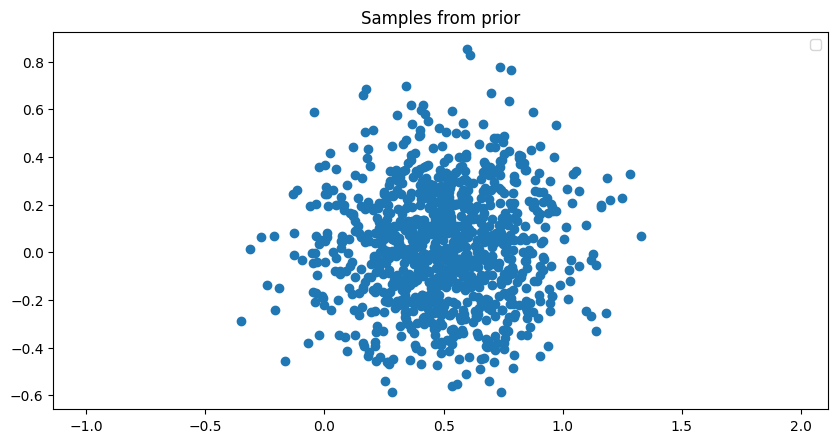

In [113]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples from prior')
plt.scatter(pr_samples[:, 0].cpu(), pr_samples[:, 1].cpu())
plt.axis('equal')
plt.legend();

##Reconstruction

In [114]:
X_rec = model(X) #reconstructed data

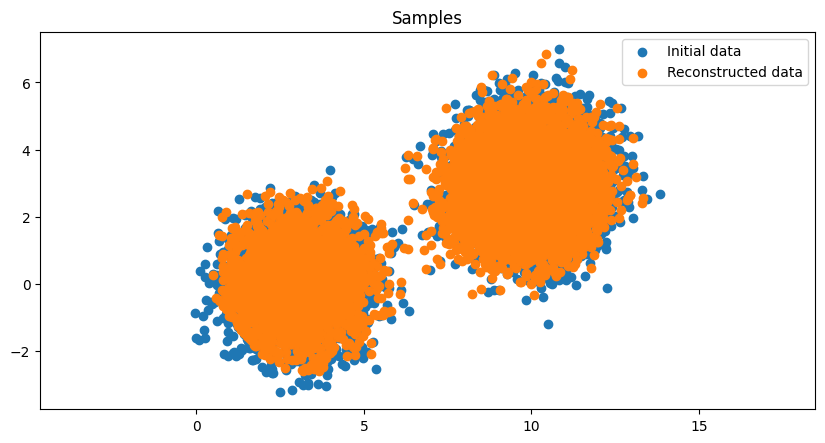

In [115]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(X_rec[0][:, 0].detach().cpu(), X_rec[0][:, 1].detach().cpu(), label='Reconstructed data')
plt.axis('equal')
plt.legend();

##Latent space vizualization

In [116]:
mu1_q, logvar1_q = model.encode(Y[Y[:, 2] == 0, 0:2])
mu2_q, logvar2_q = model.encode(Y[Y[:, 2] == 1, 0:2])

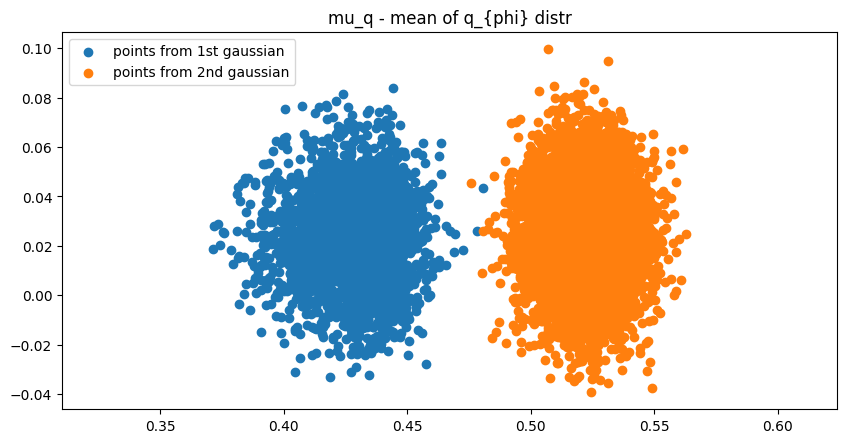

In [117]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('mu_q - mean of q_{phi} distr')
plt.scatter(mu1_q[:, 0].detach().cpu(), mu1_q[:, 1].detach().cpu(), label='points from 1st gaussian')
plt.scatter(mu2_q[:, 0].detach().cpu(), mu2_q[:, 1].detach().cpu(), label='points from 2nd gaussian')
plt.axis('equal')
plt.legend();

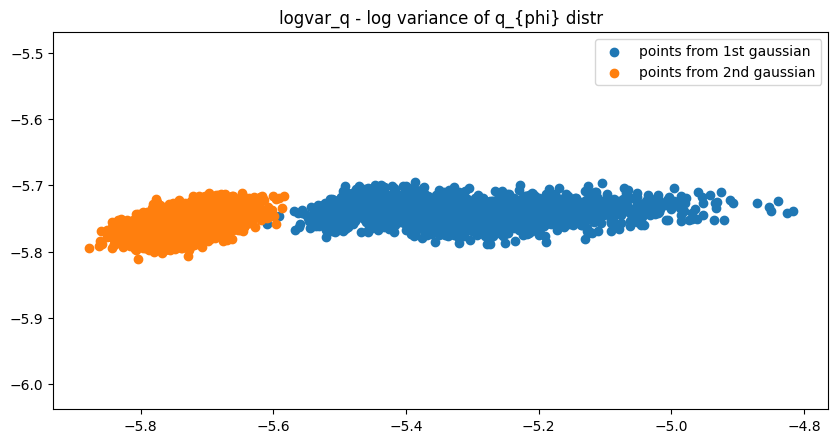

In [118]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('logvar_q - log variance of q_{phi} distr')
plt.scatter(logvar1_q[:, 0].detach().cpu(), logvar1_q[:, 1].detach().cpu(), label='points from 1st gaussian')
plt.scatter(logvar2_q[:, 0].detach().cpu(), logvar2_q[:, 1].detach().cpu(), label='points from 2nd gaussian')
plt.axis('equal')
plt.legend();